### WebNLG Challenge 2023¶

The WebNLG challenge consists in mapping data to text. For instance, given the 3 DBpedia triples shown in (a), the aim is to generate a text such as (b).

a. (John_E_Blaha birthDate 1942_08_26) (John_E_Blaha birthPlace San_Antonio) (John_E_Blaha occupation Fighter_pilot)
b. John E Blaha, born in San Antonio on 1942-08-26, worked as a fighter pilot.

More info: https://synalp.gitlabpages.inria.fr/webnlg-challenge/

Link to this colab file: https://drive.google.com/file/d/1evGzcuSOTtxoFguQiJHFLFfyQDze5mK3/view?usp=sharing

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [18]:
import gc
import pandas as pd
import numpy as np
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
import math
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the CPU


# **Load and train the data**

First convert the .xml file to csv

In [20]:
import os
import pathlib
#root_folder = '/content/drive/MyDrive/webNLG/PROJECT/Data/'
#output_folder = '/content/drive/MyDrive/webNLG/PROJECT/modified/'
#pathlib.Path(output_folder).mkdir(exist_ok=True)

#dataset_names = [
    #'University', 'Airport', 'Astronaut', 'Building', 'City', 'ComicsCharacter', 
    #'Food', 'Monument', 'SportsTeam', 'WrittenWork']

#for name in dataset_names:
  #train_path = os.path.join(root_folder, f'{name}.xml')
  #train_path_csv = os.path.join(output_folder, f'{name}.csv')

  #dev_path = os.path.join(root_folder, f'dev/{name}_dev.xml')
  #dev_path_csv = os.path.join(output_folder, f'{name}_dev.csv')

  #test_path = os.path.join(root_folder, f'test/{name}_test.xml')
  #test_path_csv = os.path.join(output_folder, f'{name}_test.csv')

  #!python /content/drive/MyDrive/webNLG/PROJECT/Data/xml-csv_script.py {train_path} {train_path_csv}
  #!python /content/drive/MyDrive/webNLG/PROJECT/Data/xml-csv_script.py {dev_path} {dev_path_csv}
  #!python /content/drive/MyDrive/webNLG/PROJECT/Data/xml-csv_script.py {test_path} {test_path_csv}

Combine the different dataset for both the train and dev set into one df

In [21]:
import glob

#For Train
# Get CSV files list from a folder
all_data_path = '/content/drive/MyDrive/webNLG/PROJECT/modified'
train_csv_files = glob.glob(all_data_path + "/*.csv");

# Read each CSV file into DataFrame
# This creates a list of dataframes
train_data_list = (pd.read_csv(file) for file in train_csv_files);

# Concatenate all DataFrames
all_train_data  = pd.concat(train_data_list, ignore_index=True);
train_data = all_train_data


# For DEV
dev_data_path = '/content/drive/MyDrive/webNLG/PROJECT/modified/dev'
dev_csv_files = glob.glob(dev_data_path + "/*.csv");

# Read each CSV file into DataFrame
# This creates a list of dataframes
dev_data_list = (pd.read_csv(file) for file in dev_csv_files);

# Concatenate all DataFrames
all_dev_data  = pd.concat(dev_data_list, ignore_index=True);
dev_data = all_dev_data


In [22]:
#load the train datatset

train_data= train_data.sample(frac=1)
train_data=train_data.sample(frac=1)
batch_size=8
num_of_batches=math.floor(len(train_data)/batch_size)

In [23]:
train_data.head()

,prefix,input_text,target_text
766,webNLG,"['Ann_Arbor,_Michigan | leader | Christopher_T...","['Christopher Taylor, politician, leads Ann Ar..."
160,webNLG,['Alpena_County_Regional_Airport | runwayName ...,['7/25 is the runway name of Alpena County Reg...
1238,webNLG,['Philippines | ethnicGroup | Ilocano_people'],['Ilocano people are an ethnic group from the ...
1652,webNLG,"['A_Loyal_Character_Dancer | numberOfPages | ""...",['A loyal Character Dancer is 360 pages long.'...
1097,webNLG,['Bakewell_pudding | dishVariation | Bakewell_...,['A variant of bakewell pudding is bakewell ta...


In [24]:
#moving the model to device(GPU/CPU)

%%capture
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
model.to(dev)

###Loading the Optimizer

In [25]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [26]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [27]:
num_of_epochs=3

###Train the model

In [28]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):

    inputbatch=[]
    labelbatch=[]
    new_data=train_data[i*batch_size:i*batch_size+batch_size]
    for index,row in new_data.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,truncation=True,padding=True,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,truncation=True,padding=True,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
  
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.507694617582009
Running epoch: 2


Epoch: 2 , Running loss: 0.3114594674832083
Running epoch: 3


Epoch: 3 , Running loss: 0.2543078852074029


### Ploting for Loss

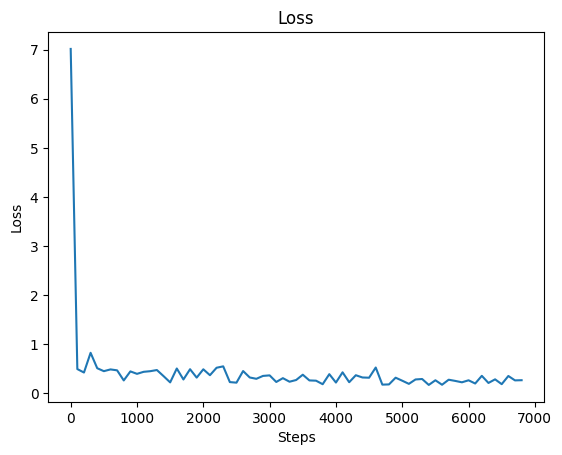

In [29]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

### Testing the Model

In [30]:
model.eval()
input_ids = tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0], skip_special_tokens=True).replace('[','').replace("'","")
     

'Putin is the leader of Russia., Putin Putin is the leader'

In [31]:
def make_prediction(model, text):
  model.eval()
  input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
  input_ids=input_ids.to(dev)
  outputs = model.generate(input_ids)
  return tokenizer.decode(outputs[0], skip_special_tokens=True).replace('[','').replace("'","")

make_prediction(model, 'Putin | leader | Russia')

'Putin is a leader in Russia. Putin is the leader of Russia. Putin is the leader'

In [32]:
dev_data = pd.read_csv('/content/drive/MyDrive/webNLG/PROJECT/Modified/University_dev.csv', index_col=[0])
test_data = pd.read_csv('/content/drive/MyDrive/webNLG/PROJECT/Modified/University_test.csv', index_col=[0])

In [39]:
#geting the inputs (input_text) from the dataset
dev_data_inputs = [ x.replace('[','').replace(']','') for x in dev_data['input_text'].values.tolist() ]

#feeding the input into the model and getting the predictions
dev_data_predictions = [ make_prediction(model, x) for x in dev_data_inputs ]

#loading the reference values from the target_text column
dev_data_reference = [ x.replace('[','').replace(']','') for x in dev_data['target_text'].values.tolist() ]

In [41]:
## Creating both files for the ref and hypothesis as requested by the eval
open('dev_reference.txt', 'w+').close()
open('dev_hypothesis.txt', 'w+').close()

with open('dev_reference.txt','a+') as f:
  for row in dev_data_reference:
    print(row, file=f)

with open('dev_hypothesis.txt', 'a+') as f:
  for row in dev_data_predictions:
    print(row, file=f)

###Evaluating the model


In [35]:
### No requirement.txt file was found in the repository
### The process tried to overide the requirement.txt and install the other dependencies (meteor and bleurt), however they are not being used

!git clone https://github.com/WebNLG/2023-Challenge.git
%pushd 2023-Challenge/evaluation/automatic/scripts
!./install_dependencies.sh
%popd

Cloning into '2023-Challenge'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 201 (delta 95), reused 107 (delta 37), pack-reused 0
Receiving objects: 100% (201/201), 7.67 MiB | 3.23 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/2023-Challenge/evaluation/automatic/scripts
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'bleurt'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 134 (delta 0), reused 17 (delta 0), pack-reused 116
Receiving objects: 100% (134/134), 31.28 MiB | 32.03 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [42]:
!pip install pyter3 bert_score razdel tabulate sacrebleu -qqq

In [43]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
#removed meteor because of this 'Error: Unable to access jarfile metrics/meteor-1.5/meteor-1.5.jar'
#removed bleurt because its not implemented in the eval.py (also commented the import code line out)

!python /content/drive/MyDrive/webNLG/PROJECT/Data/eval.py -hyp dev_hypothesis.txt -ref dev_reference.txt -nr 1 -m bleu,chrf++,ter -lng en




STARTING TO PARSE INPUTS...
FINISHING TO PARSE INPUTS...
STARTING TO COMPUTE CHRF++...
FINISHING TO COMPUTE CHRF++...
STARTING TO COMPUTE TER...
FINISHING TO COMPUTE TER...
   BLEU    chrF++    TER
-------  --------  -----
3.59959      0.27   0.77
